









































# Семинар 7: Few/Zero Shot Learning


## Вступление
Мы привыкли, что задача машинного обучения предполагает наличие большого количества данных. А что если:

1. Существуют какие-то редкие случаи, примеров которых в обучающей выборке всего несколько штук. Тогда формально мы имеем задачу классификации на $C$ классов, из них $K < C$ классов имеют мало обучающих примеров, и нужно уметь различать между всеми классами, как многочисленными, так и малочисленными.

2. Для какой-то задачи в целом может быть сложно (долго, дорого, ненадежно...) собирать какие-то данные (например, компьютерная томография или МРТ). Здесь же у нас всего $K$ классов, и для каждого из этих классов имеется мало объектов в выборке.

Для таких задач был разработан ряд __Few Shot Learning__ алгоритмов. Если у нас $K$ редких классов, каждый из которых представлен $N$ объектами, то в англоязычной литературе такая Few Shot задача называется __$K$-way $N$-shot__ классификацией/регрессией/детекцией/...

Сегодня мы познакомимся с решениями, которые позволяют получать адекватное качество предсказаний, несмотря на крайне маленькое (или даже совсем отсутствующее!) количество данных.

### План семинара:
0. Подгрузим данные для Few Shot классификации
1. Metric Learning для Few Shot классификации
2. Meta Learning для Few Shot классификации
3. Zero Shot классификация

## 0. Подгрузим данные для Few Shot классификации

In [ ]:
!pip install pytorch-lightning -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.3 MB/s eta 0:00:00


In [ ]:
!pip install higher -q

In [ ]:
import warnings
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict

import pytorch_lightning as pl
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchmetrics.functional import accuracy
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchmetrics.functional import accuracy as tm_accuracy
import higher

warnings.filterwarnings("ignore")
%matplotlib inline

Для начала соберем себе маленькую выборку. Пускай это будет подвыборка хорошо знакомой нам выборки CIFAR10, в которой 10 классов цветных изображений размера 32х32.

Сделаем класс `CifarSubset`, который будет представлять собой dataset, состоящий из подвыборки __N__ объектов каждого из 10 классов.

In [ ]:
class CifarSubset(torchvision.datasets.vision.VisionDataset):
    def __init__(self, root, k_n, train: bool, download: bool, transform):
        super().__init__(root, transform=transform, target_transform=None)

        self.k_n = k_n
        self.data = self.__sample_uniform_subset(root, train, download, transform)

    def __sample_uniform_subset(self, root, train, download, transform):
        """
        Метод вернет такую подвыборку выборки CIFAR10,
        что объектов каждого класса будет ровно k_n штук.

        :param: dataset — исходная выборка
        :param: k_n — количество объектов в каждом классе
        """

        self.cifar_full = torchvision.datasets.CIFAR10(
            root=root, train=train, download=download, transform=transform
        )

        number_of_classes = len(self.cifar_full.classes)
        class_count = [0 for _ in range(number_of_classes)]
        subset = []

        for image, label in self.cifar_full:
            # мы хотим ровно k_n объектов каждого класса
            if class_count[label] < self.k_n:
                subset.append((image, label))
                class_count[label] += 1

            # если каждый класс имеет k_n объектов - выходим из цикла
            if sum(class_count) == number_of_classes * self.k_n:
                break
        return subset

    def __getitem__(self, index):
        return self.data[index][0], self.data[index][1]

    def __len__(self):
        return len(self.data)

In [ ]:
N_SHOT = 5  # количество объектов каждого класса в обучающей выборке

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

cifar_train_subset = CifarSubset(
    root="./cifar", k_n=N_SHOT, train=True, download=True, transform=transform
)

cifar_val_subset = CifarSubset(
    root="./cifar", k_n=N_SHOT, train=False, download=True, transform=transform
)

100%|██████████| 170M/170M [00:06<00:00, 28.4MB/s]


Многие алгоритмы для Few Shot (и особенно Meta) Learning лучше тренировать так называемыми __эпизодами__, где эпизодом называют ситуацию, максимально приближенную к условиям инференса. Например, если во время инференса мы будем просить модель классифицировать __N__ объектов каждого из __K__ классов, то и тренировать ее стоит батчами по __N__ * __K__ классов.

И так как в нашем случае __N__ * __K__ — это и есть _все_ наши данные, то у нас один эпизод эквивалентен одной эпохе.

In [ ]:
# тк нам нужно обучаться эпизодами, батч должен содержать в себе сразу все данные
train_dataloader = torch.utils.data.DataLoader(
    cifar_train_subset,
    batch_size=N_SHOT * 10,  # 10 потому что в нашей выборке 10 классов
    shuffle=True,
    num_workers=1,
)
val_dataloader = torch.utils.data.DataLoader(
    cifar_val_subset, batch_size=N_SHOT * 10, shuffle=True, num_workers=1
)

Если воспользоваться решениями, которые были у нас до сегодняшнего дня, то модель просто не выучит никаких закономерностей малочисленного класса и сильно переобучится.

Специально для таких задач был разработан ряд алгоритмов - несколько из них мы сегодня рассмотрим!

---

## 1. Few Shot learning

Основная цель подходов данного вида - понять как выглядят выученные признаки (или эмбеддинги) типичного представителя каждого класса. Имея такие "прототипы" классов можно будет сравнивать признаки каждого из объектов с признаками каждого прототипа и выбирать тот, который наиболее похож на наш объект. Для того чтобы это работало, нужно убедиться, что во время обучения мы делаем так, что похожие объекты находятся рядом в пространстве признаков, а непохожие — далеко друг от друга (совсем как в задаче кластеризации).

---

Верхнеуровнево это всегда выглядит примерно одинаково:

1. На тех данных, что у нас имеются, обучается какая-то модель, выходом которой будут __не вероятности классов__, а __многомерный вектор признаков__ (можно взять любую из наших предыдущих моделей классификации/регрессии и отбросить последний классификационный слой).

2. Функция потерь подбирается таким образом, чтобы модель училась группировать между собой похожие данные.

3. В случае __K__-way __N__-shot классификации как во время обучения, так и во время инференса, происходит одно и то же. Какой-то процент из __N__ объектов каждого класса выбирается для формирования прототипа класса путем усреднения их признаков. Такая подвыборка будет называться вспомогательным множеством или __support set__. А оставшиеся объекты (которые мы, собственно, будем сравнивать с этим прототипом) называются множеством запросов или __query set__.

---

1. Построим простую свёрточную архитектуру, выходом которой для каждого объекта будет многомерный вектор выученных признаков:

In [ ]:
class PrototypeNet(nn.Module):
    def __init__(self, input_dim=3, hid_dim=64, output_dim=64):
        super(PrototypeNet, self).__init__()

        self.encoder = nn.Sequential(
            self.__conv_block(input_dim, hid_dim),
            self.__conv_block(hid_dim, hid_dim),
            self.__conv_block(hid_dim, hid_dim),
            self.__conv_block(hid_dim, output_dim),
        )

    def __conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

2. Теперь нужно выбрать такой функционал потерь, который будет штрафовать за:

  - большие расстояния между объектом и прототипом его класса
  - маленьки расстояния между объектом и прототипом _не_ его класса

  Так как готовых решений в торче нет, придется писать свой Loss... Чтобы не подбирать математику, описывающую нужные нам условия, воспользуемся подходом, представленным в [данной работе](https://arxiv.org/pdf/1703.05175.pdf). Тогда формирование функционала ошибки будет выглядеть следующим образом:

---

- Для каждого класса $c$:
    - Для каждого объекта $q$ из нашего __query_set($с$)__
      
  $$
  Loss +=  {1 \over N_c * N_q} * \left[\text{dist}(\text{emb}(q), p_c) + \log{\sum_{classes} e^{-\text{dist}(\text{emb}(q), p_{class})}} \right],
  $$

  где $\text{emb}(q)$ — эмбеддинг, полученный после того как объект $q$ прошел через нашу свёрточную сеть, а $\text{dist}(\text{emb}(q), p_c)$ — какая-то функция расстояния между этим эмбеддингом и прототипом $p_c$ класса $c$.
---
  С первого взгляда происходит что-то страшное, и непонятно почему взяты именно такие значения. Но если приглядеться, то будет понятно, что первое слагаемое в скобках - это просто расстояние от нашего объекта до прототипа своего класса, а второе слагаемое (в виде суммы) становится тем меньше, чем дальше наш объект от всех остальных прототипов.
  
  Таким образом, минимизируя представленный функционал по параметрам нейросети, мы как раз приближаем наш объект к своему прототипу и отдаляем от всех остальных!

In [ ]:
class PrototypeLoss(nn.Module):
    def __init__(self, n_shot: int):
        super(PrototypeLoss, self).__init__()
        self.n_shot = n_shot
        self.__prototypes: list = None

    def __distance(self, inp, other):
        return torch.linalg.norm(inp - other) # Евклидово расстояние между двумя векторами.

    def __prototype_loss(
        self,
        predicted_embeddings: torch.Tensor,
        target_labels: torch.Tensor,
        support_percent: float = 0.6,
    ):
        """
        :param predicted_embeddings: векторы признаков, полученные в результате работы модели; shape = (N, emb_size)
        :param target_labels: список целевых классов; shape=(N)
        :param: support_percent: процент данных каждого класса, который будет использоваться для формирования прототипа класса
        """

        assert 0 < support_percent < 1

        classes = torch.unique(target_labels)
        n_classes = len(classes)  # количество классов за эпизод

        # количество данных для определения прототипа класса
        n_support = int(self.n_shot * support_percent)
        # количество данных для сравнения с прототипом класса
        n_query = self.n_shot - n_support

        prototypes = []  # прототипы класса (количество классов, вектор признаков)
        class_queries = []

        for c in classes:
            supports = predicted_embeddings[target_labels == c][:n_support]
            queries = predicted_embeddings[target_labels == c][n_support:]

            # прототип класса - это усредненное значение всех support объектов
            prototypes.append(supports.mean(0))
            # запросы класса - это все объекты, не попавшие в support
            class_queries.append(queries)

        loss = torch.tensor(0.0)

        for i, queries in enumerate(class_queries):
            for query in queries:  # пробегаемся по всем объектам класса i
                loss += self.__distance(prototypes[i], query)

                distances = torch.stack(
                    [
                        self.__distance(query, p)
                        for ci, p in enumerate(prototypes)
                        if i != ci
                    ]
                )
                # добавим значение, обратное сумме этих расстояний
                # чем больше расстояния, тем меньше мы наказываем модель

                loss += torch.log(torch.sum(torch.exp(-distances)))

        # сохраним прототипы для возможности дальнейших предсказаний
        self.prototypes = torch.stack(prototypes)

        return loss / (n_classes * n_query)

    def forward(self, predicted_embeddings, targets) -> torch.Tensor:
        return self.__prototype_loss(predicted_embeddings, targets)

    def get_class_prototypes(self) -> list:
        return self.__prototypes

Теперь осталось знакомым нам образом собрать все это дело в один LightningModule

In [ ]:
class FewShotMetricLearner(pl.LightningModule):
    def __init__(self, n_shot: int) -> None:
        super().__init__()

        self.model = PrototypeNet()
        self.loss = PrototypeLoss(n_shot)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-2)
        # это значение заполнится позже, во время расчета ошибки
        self.prototypes = None

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return self.optimizer

    def predict_labels(self, batch_embeddings):
        if self.prototypes == None:
            raise ValueError("self.prototypes was not set")

        ans = []
        for e in batch_embeddings:
            dists = torch.linalg.norm(self.prototypes - e, dim=1)
            ans.append(torch.argmin(dists))

        return torch.stack(ans)

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        embeddings = self.forward(images)

        loss = self.loss(embeddings, target)
        # label_predictions = self.predict_labels(embeddings)

        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        embeddings = self.forward(images)

        loss = self.loss(embeddings, target)
        self.prototypes = self.loss.prototypes

        label_predictions = self.predict_labels(embeddings)
        acc = accuracy(label_predictions, target, task ='multiclass', num_classes=10)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

In [ ]:
few_shot_metric_learner = FewShotMetricLearner(n_shot=N_SHOT)

trainer = pl.Trainer(accelerator="cpu", max_epochs=50)
trainer.fit(few_shot_metric_learner, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PrototypeNet  | 113 K  | train
1 | loss  | PrototypeLoss | 0      | train
------------------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.452     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
len(cifar_train_subset)

50

In [ ]:
len(cifar_val_subset)

50

Мы классифицируем объекты с accuracy 0.6-0.7, обучив (__примерно за минуту на cpu__) простейшую свёрточную сеть всего на __5 объектах (!!!)__ каждого класса.

---

## 2. Few Shot Meta Learning
    
Мета обучение ставит перед собой задачу "научиться учиться". В нашем случае, "научиться классифицировать". Это более общая задача, ведь в случае обучения с учителем мы не просто "учимся классифицировать", а "учимся классифицировать на конкретные классы". Давайте подробнее рассмотрим один из Meta Learning алгоритмов.

__Model Agnostic Meta Learning (MAML)__ [ссылка на статью](https://arxiv.org/pdf/1703.03400.pdf)

Целью Few Shot мета обучения является обучение модели, которая может быстро адаптироваться к новой задаче, используя всего несколько объектов и итераций обучения.По сути, проблема __мета обучения__ рассматривает __целые задачи как обучающие примеры__. То есть целая задача классификации на кошек и собак — это один объект обучающей выборки, на машины и самолеты — второй объект обучающей выборки и так далее.

1. При решении эпизода __K__-way __N__-shot классификации мы каждый эпизод показываем __разные K классов__!
2. Во время эпизода мы используем _train_ выборку для того, чтобы обучать классификатор (любую привычную нам архитектуру, именно отсюда Model Agnostic в названии) так, как мы делали в обычной задаче классификации.
3. После эпизода мы используем ошибку и лосс на _val_ выборке (где у нас уже другое множество задач классификации) для того, чтобы провести мета обучение.
4. В конце обучения используется _test_ выборка, состоящая из нескольких _(не показанных ни в val, ни в test)_ задач классификации, на которой и измеряется качество работы модели.

![a](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/few-shot-classification.png)

За счет этого и получается обобщение. Модель учится не просто отличать данные __K__ классов, а в целом - отличать между собой __любые K классов__ по __N__ примерам. А процесс мета обучения находит и адаптирует наиболее задаче-чувствительные параметры модели. Стоит отметить, что это всего лишь один представитель огромного множества Meta Learning алгоритмов.

P.S. Существует библиотека [pytorch-meta](https://github.com/tristandeleu/pytorch-meta) (это не официальная реализация от команды pytorch, но полезный функционал найти можно), в которой есть реализации известных Meta Learning алгоритмов, в том числе - [имплементация алгоритма MAML](https://github.com/tristandeleu/pytorch-meta/tree/master/examples/maml), который мы разобрали выше.

---

### MAML реализация для MNIST

Будем использовать библиотеку [`higher`](https://github.com/facebookresearch/higher) для реализации **внутренней петли адаптации (inner loop)** в задачах мета-обучения.
Обычные оптимизаторы PyTorch не позволяют дифференцировать сквозь процесс обучения, поэтому `higher` решает эту проблему.

* Позволяет создавать **временные копии модели** с отдельными параметрами (`fmodel`), не затрагивая исходную.
* Поддерживает **обратное распространение через шаги обучения**, что необходимо для MAML и подобных методов.
* Предоставляет интерфейс `innerloop_ctx`, который позволяет использовать знакомый PyTorch-код (forward, backward, step), но при этом сохраняет вычислительный граф.

1. Исходная модель передаётся в `higher.innerloop_ctx` вместе с внутренним оптимизатором.
2. Внутри контекста создаётся адаптируемая копия модели (`fmodel`) и обёртка оптимизатора (`diffopt`).
3. В течение нескольких шагов адаптации параметры `fmodel` обновляются по support-примерам.
4. После этого на query-примерах вычисляется мета-потеря, по которой происходит обновление исходной модели.

Таким образом, `higher` позволяет организовать **градиентную адаптацию внутри цикла обучения**, не ломая граф вычислений и не дублируя код обучения вручную.
Этот подход является стандартным для реализации алгоритма **MAML (Model-Agnostic Meta-Learning)** и его вариаций.


Использование @dataclass обеспечивает удобный и читаемый способ хранения всех гиперпараметров в одном месте.

Основные параметры

**device** — автоматический выбор между cuda и cpu для ускорения вычислений при наличии GPU.

**n_way** = 5 — количество классов в каждой задаче (N-way), типично для few-shot экспериментов.

**k_shot** = 5 — количество обучающих примеров на класс (K-shot), то есть 5 изображений на класс.

**q_query** = 5 — количество тестовых (query) примеров на класс, используется для оценки качества адаптации.

**inner_steps** = 1 — число шагов внутреннего градиентного обновления. В практике мета-обучения часто используют 1–5 шагов, чтобы сбалансировать скорость и устойчивость обучения.

**inner_lr** = 0.4 — скорость обучения внутреннего оптимизатора. Относительно высокий learning rate ускоряет адаптацию на малом числе шагов.

**meta_lr** = 1e-3 — скорость обучения мета-оптимизатора (например, Adam), управляющего обновлением «базовых» параметров модели.

**meta_batch** = 4 — количество задач (эпизодов), обрабатываемых в одной мета-итерации.

**meta_iters** = 400 — количество итераций мета-обучения. Значение 400 выбрано для наглядных экспериментов; для получения стабильного качества рекомендуется 5000–10000 итераций.

In [ ]:
@dataclass
class Cfg:
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    n_way: int = 5
    k_shot: int = 5
    q_query: int = 5
    inner_steps: int = 1      # попробуй 1..5
    inner_lr: float = 0.4
    meta_lr: float = 1e-3
    meta_batch: int = 4
    meta_iters: int = 400    # для наглядности; увеличь до 5k–10k для лучшего качества
    data_root: str = "./data"

cfg = Cfg()

Реализована компактная свёрточная нейронная сеть ConvNetMNIST, предназначенная для задач few-shot обучения на изображениях из датасета MNIST (размер входа — 1×28×28).

Архитектура следует принципам, типичным для мета-обучения: простая, устойчивая и достаточно выразительная для быстрой адаптации к новым классам.

In [ ]:
class ConvNetMNIST(nn.Module):
    def __init__(self, out_dim: int):
        super().__init__()
        def block(ci, co):
            return nn.Sequential(
                nn.Conv2d(ci, co, 3, padding=1, bias=False),
                nn.GroupNorm(1, co),      # стабильнее, чем BatchNorm на маленьких эпизодах
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )
        self.enc = nn.Sequential(
            block(1, 64),   # 28 -> 14
            block(64, 64),  # 14 -> 7
            block(64, 64),  # 7  -> 3
            block(64, 64),  # 3  -> 1
        )
        self.head = nn.Linear(64, out_dim)

    def forward(self, x):
        f = self.enc(x)            # [B,64,1,1]
        f = f.view(x.size(0), -1)  # [B,64]
        return self.head(f)        # [B,out_dim]

Функция build_class_index предназначена для создания структуры данных, удобной для выборки примеров по классам.

**Алгоритм работы:**


1.   Выполняется проход по всему датасету.
2.   Для каждого элемента извлекается метка класса y.
3.   Индекс примера добавляется в словарь by_class, где ключ — это класс, а значение — список индексов всех соответствующих ему примеров.
4.   Если класс встречается впервые, для него создаётся новый список.

В результате формируется словарь вида:

```
{
  class_0: [idx0, idx1, ...],
  class_1: [idx2, idx3, ...],
  ...
}
```

**sample_episode**(dataset, by_class, classes_pool, n_way, k_shot, q_query, rng)

Функция формирует один эпизод few-shot обучения в формате N-way K-shot.
Пошаговая логика:

1.  Из пула доступных классов случайным образом выбираются n_way классов.

2.  Для каждого выбранного класса случайным образом отбирается k_shot + q_query индексов.



*   Первые k_shot используются как обучающие (support) примеры.
*   Последующие q_query — как тестовые (query) примеры.



3.  Метки классов перенумеровываются локально (от 0 до n_way-1), чтобы не зависеть от глобальной нумерации датасета.

4.  Из выбранных индексов извлекаются изображения, которые объединяются в тензоры:

* Xs, Ys — support-примеры и их метки;

* Xq, Yq — query-примеры и их метки.

5.  Все изображения укладываются в батчи с помощью torch.stack.

Таким образом, каждая выборка sample_episode создаёт самостоятельную мини-задачу классификации, которая используется для мета-обучения моделей few-shot.

In [ ]:
def build_class_index(dataset) -> Dict[int, List[int]]:
    byc: Dict[int, List[int]] = {}
    for i in range(len(dataset)):
        _, y = dataset[i]
        y = int(y)
        byc.setdefault(y, []).append(i)
    return byc

def sample_episode(dataset, by_class: Dict[int, List[int]], classes_pool: List[int],
                   n_way, k_shot, q_query, rng: random.Random):
    classes = rng.sample(classes_pool, n_way)
    xs, ys, xq, yq = [], [], [], []
    for new_y, cls in enumerate(classes):
        pool = by_class[cls]
        idxs = rng.sample(pool, k_shot + q_query)
        s_idx, q_idx = idxs[:k_shot], idxs[k_shot:]
        for i in s_idx:
            x, _ = dataset[i]; xs.append(x); ys.append(new_y)
        for i in q_idx:
            x, _ = dataset[i]; xq.append(x); yq.append(new_y)
    Xs = torch.stack(xs, 0); Ys = torch.tensor(ys, dtype=torch.long)
    Xq = torch.stack(xq, 0); Yq = torch.tensor(yq, dtype=torch.long)
    return Xs, Ys, Xq, Yq

Загрузка нашего MNIST датасета для Few-short.

In [ ]:
def load_mnist():
    tfm = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_ds = datasets.MNIST(cfg.data_root, train=True, download=True, transform=tfm)
    test_ds  = datasets.MNIST(cfg.data_root, train=False, download=True, transform=tfm)

    # meta-train классы: 0-4, meta-test классы: 5-9 (полностью раздельные)
    train_classes = [0,1,2,3,4]
    test_classes  = [5,6,7,8,9]

    train_byc = build_class_index(train_ds)
    test_byc  = build_class_index(test_ds)
    return train_ds, test_ds, train_byc, test_byc, train_classes, test_classes

Функция `meta_train` реализует процесс мета-обучения модели в парадигме **episodic few-shot learning** с использованием **градиентной адаптации во внутренней петле (inner loop)** и **обновления мета-параметров во внешней петле (outer loop)**.

1. **Подготовка к обучению**

   * Модель переводится на выбранное устройство (`cuda` или `cpu`).
   * Инициализируется оптимизатор Adam для обновления мета-параметров.
   * Задаётся генератор случайных чисел для воспроизводимости.
   * Модель переводится в режим обучения.

2. **Внешняя петля (meta-итерации)**
   Цикл выполняется `cfg.meta_iters` раз.
   На каждой итерации:

   * Обнуляются градиенты мета-оптимизатора.
   * Инициализируется накопитель мета-потерь `meta_loss`.

3. **Формирование батча эпизодов**
   Для каждой итерации внешней петли формируется `cfg.meta_batch` независимых эпизодов с помощью `sample_episode`.
   Каждый эпизод содержит:

   * Support-примеры (`Xs`, `Ys`)
   * Query-примеры (`Xq`, `Yq`)
     Данные переносятся на устройство обучения.

4. **Внутренняя петля адаптации (inner loop)**

   * Инициализируется временный оптимизатор SGD для быстрой адаптации параметров.
   * С помощью библиотеки `higher` создаётся контекст `innerloop_ctx`, позволяющий дифференцировать сквозь адаптацию.
   * В течение `cfg.inner_steps` шагов:

     * Вычисляется функция потерь по support-примерам.
     * Параметры временной модели (`fmodel`) обновляются градиентным шагом.

5. **Оценка на query-примерах**
   После адаптации вычисляется функция потерь на `Xq`, `Yq`.
   Потери аккумулируются в `meta_loss` для всех эпизодов.

6. **Обновление мета-параметров (outer loop)**

   * Среднее значение `meta_loss` по батчу эпизодов используется для расчёта градиентов.
   * Параметры исходной модели обновляются шагом Adam.

7. **Логирование**
   Каждые 100 итераций выводится текущее значение мета-потерь для отслеживания прогресса обучения.

В результате выполнения функции:

* Модель обучается **не конкретной задаче**, а **умению быстро адаптироваться** к новым задачам на основе нескольких примеров (few-shot).
* Внешний цикл отвечает за обновление мета-параметров,
  а внутренний — за быструю адаптацию к каждой задаче.


In [ ]:
def meta_train(model, train_ds, train_byc, train_classes):
    model.to(cfg.device)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.meta_lr)
    rng = random.Random(0)
    model.train()

    for it in range(1, cfg.meta_iters + 1):
        opt.zero_grad()
        meta_loss = 0.0
        for _ in range(cfg.meta_batch):
            Xs, Ys, Xq, Yq = sample_episode(
                train_ds, train_byc, train_classes, cfg.n_way, cfg.k_shot, cfg.q_query, rng
            )
            Xs, Ys, Xq, Yq = Xs.to(cfg.device), Ys.to(cfg.device), Xq.to(cfg.device), Yq.to(cfg.device)

            # inner-loop с higher
            inner_opt = torch.optim.SGD(model.parameters(), lr=cfg.inner_lr)
            with higher.innerloop_ctx(model, inner_opt, copy_initial_weights=False) as (fmodel, diffopt):
                for _ in range(cfg.inner_steps):
                    logits_s = fmodel(Xs)
                    loss_s = F.cross_entropy(logits_s, Ys)
                    diffopt.step(loss_s)

                logits_q = fmodel(Xq)
                loss_q = F.cross_entropy(logits_q, Yq)

            meta_loss = meta_loss + loss_q

        meta_loss = meta_loss / cfg.meta_batch
        meta_loss.backward()
        opt.step()

        if it % 100 == 0:
            print(f"[meta-train] iter {it}/{cfg.meta_iters}  meta_loss={meta_loss.item():.4f}")

    return model

Имплементация внешего цикла для предсказания и отсмотра accuracy на новых данны.

В данном коде мы делаем два теста - просто на модели без адаптации к новой задаче (acc_before_adaptation) и с адаптацией (demo_meta_test)

In [ ]:
@torch.no_grad()
def acc_before_adaptation(model, Xq, Yq) -> float:
    model.eval()
    logits = model(Xq)
    preds = logits.argmax(dim=-1)
    return (preds == Yq).float().mean().item()

def acc_after_adaptation(model, Xs, Ys, Xq, Yq, inner_steps, inner_lr) -> float:
    # важно: нужен enable_grad в адаптации
    with torch.enable_grad():
        inner_opt = torch.optim.SGD(model.parameters(), lr=inner_lr)
        with higher.innerloop_ctx(model, inner_opt, copy_initial_weights=False) as (fmodel, diffopt):
            fmodel.train()
            for _ in range(inner_steps):
                logits_s = fmodel(Xs)
                loss_s = F.cross_entropy(logits_s, Ys)
                diffopt.step(loss_s)
            fmodel.eval()
            logits_q = fmodel(Xq)
            preds = logits_q.argmax(dim=-1)
            return (preds == Yq).float().mean().item()


def demo_meta_test(model, test_ds, test_byc, test_classes, seed=123):
    rng = random.Random(seed)
    # соберём 1 эпизод из НОВЫХ классов (5–9)
    Xs, Ys, Xq, Yq = sample_episode(
        test_ds, test_byc, test_classes, cfg.n_way, cfg.k_shot, cfg.q_query, rng
    )
    Xs, Ys, Xq, Yq = Xs.to(cfg.device), Ys.to(cfg.device), Xq.to(cfg.device), Yq.to(cfg.device)

    before = acc_before_adaptation(model, Xq, Yq)
    after  = acc_after_adaptation(model, Xs, Ys, Xq, Yq, cfg.inner_steps, cfg.inner_lr)

    print(f"\n[meta-test @ MNIST, classes 5–9] {cfg.n_way}-way {cfg.k_shot}-shot {cfg.q_query}-query")
    print(f"Accuracy BEFORE adaptation: {before:.3f}")
    print(f"Accuracy AFTER  adaptation: {after:.3f}")
    return before, after

In [ ]:
torch.manual_seed(0)
random.seed(0)

train_ds, test_ds, train_byc, test_byc, train_classes, test_classes = load_mnist()

# Модель под n_way (локальные метки внутри эпизода)
model = ConvNetMNIST(out_dim=cfg.n_way)

# 1) Мета-обучение на цифрах 0–4
model = meta_train(model, train_ds, train_byc, train_classes)

# 2) Meta-test: НОВАЯ задача из цифр 5–9
demo_meta_test(model, test_ds, test_byc, test_classes, seed=42)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.90MB/s]


[meta-train] iter 100/400  meta_loss=0.8320
[meta-train] iter 200/400  meta_loss=0.1299
[meta-train] iter 300/400  meta_loss=0.0717
[meta-train] iter 400/400  meta_loss=0.0430

[meta-test @ MNIST, classes 5–9] 5-way 5-shot 5-query
Accuracy BEFORE adaptation: 0.120
Accuracy AFTER  adaptation: 0.640


(0.11999999731779099, 0.6399999856948853)

С адаптацией (минимальным количеством эпох GD и большим lr обучились на новую задачу на малых данных) более 0.6 по accuracy.

In [ ]:
del cfg # уберем эту переменную иначе в клипе ломается

## 3. Zero Shot Learning

### Основная идея:

В задаче __Zero-Shot__ classification/detection/segmentation мы хотим предсказывать классы/коробки/маски объектов, которые ни разу не встречали во время обучения. Например, мы все обучение проводили на кошках и собаках, а модель умеет классифицировать еще и львов. Zero-shot модели обучаются на одних данных, а тестируются на тех, которые во время обучения не были показаны.

**Зачем нужен zero-shot?**
Может быть такое, что разметка — непростительно долгая и дорогая операция. Конструкция моделей Zero-shot позволяет использовать знания из одной области (например из текстов), чтобы иметь возможность предсказывать невиданные во время обучения классы по изображению.

С zero-shot моделями будем знакомиться на примере очень известной архитектуры CLIP (Contrastive Language–Image Pre-training). Далее в семинаре — краткий пересказ [статьи](https://openai.com/blog/clip/) из блога компании, создавшей архитектуру.

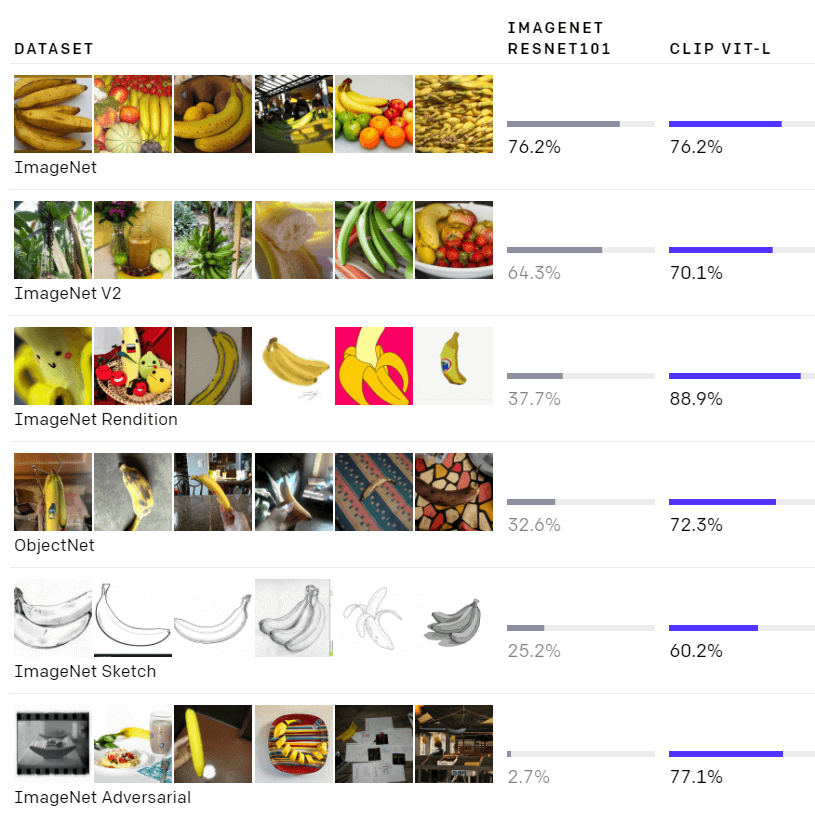

Данные состоят из картинок из интернета с подписями к ним. То есть один объект тренировочной выборки — это пара (изображение, текстовое описание). Например, фотография собаки и подпись "Это моя собака". А процесс обучения строится из таких шагов:

__1. Contrastive pre-training__

- Существуют две модели: одна — для извлечения признаков из изображения, вторая — для извлечения признаков из текста. Можете представлять себе любую свёрточную архитектуру без последнего слоя. На изображении ниже — Image Encoder и Text Encoder соответственно.

- Далее обучаем такой лосс, чтобы расстояние между извлеченными признаками изображения и извлеченными признаками текста были маленькими для соответствующей пары (изображение, текстовое описание) и большими для всех остальных.

  То есть вектор признаков, извлеченный из изображения собаки, должен быть похож на вектор признаков, извлеченный из текста "Это моя собака", и очень не похож на вектор признаков от подписи к другой фотографии.

- Таким образом, модель учится определять, насколько какое-то изображение релевантно к тексту и наоборот.

__(2) and (3).  Create dataset classifier from label text__

Когда во время тестирования нужно классифицировать новое изображение, мы сравниваем признаки, извлеченные из этого изображения, с признаками, извлеченными из __N__ текстов, специально заготовленных нами заранее. __N__ — общее количество классов, в которое входят как классы, которые были во время обучения, так и классы, которых не было. Специальная заготовка текстов заключается в том, что эти тексты формируются по какой-то заготовке формата "Это фотография {класс}", и дальше для каждого из __N__ классов просто вставляется название класса. Из-за того что модель умеет сравнивать признаки, извлеченные с подписей к фотографиям, и признаки, извлеченные с самих фотографий, во время тестирования мы можем просто сравнить близость признаков изображения с признаками всех искусственно созданных текстов и классифицировать изображение, выбрав самую подходящую по мнению модели подпись.


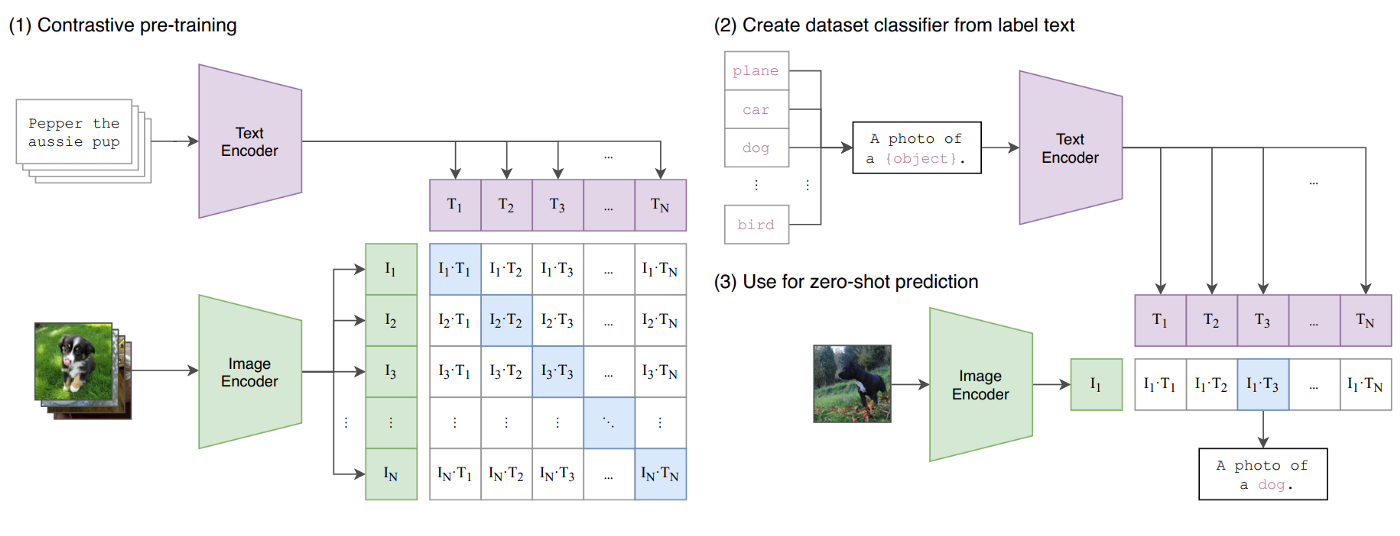

### Ограничения:
1. Плохо считает количество объектов, а также путается на цифрах, например, на MNIST
2. Если уходить в глубину класса (порода собаки или марка машины), то ошибка сильно возрастает

### Теперь посмотрим, что можно поделать с этой моделью в коде

In [ ]:
!pip install -q git+https://github.com/openai/CLIP.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

Torch version: 2.8.0+cu126


Для извлечения признаков из изображения, в статье указано несколько архитектур, на которых проводились эксперименты с моделью. Вот они слева направо (ViT - это Visual Transformer, они будут чуть позже (или сильно позже)):

In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

Мы выберем хорошо знакомый нам ResNet50.

In [ ]:
# если упадет из-за несоответствия checksum - попробуйте запустить ячейку заново
model, preprocess = clip.load("RN50x64")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|█████████████████████████████████████| 1.26G/1.26G [00:23<00:00, 56.4MiB/s]


Model parameters: 623,258,305
Input resolution: 448
Context length: 77
Vocab size: 49408


Вспоминаем из предыдущего модуля, что прежде чем работать с текстом, его надо токенизировать.

In [ ]:
clip.tokenize("Hello World!")  # "Hello World!" -> "<BOS>Hello World!<EOS>"

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [ ]:
# Пространство эмбеддингов длины 77
clip.tokenize("Hello World!").size()

torch.Size([1, 77])

Посмотрим, насколько хорошо модель понимает разные по написанию, но схожие по сути предложения.

In [ ]:
tensor1 = clip.tokenize("google cloud platform").to(torch.float32)
tensor2 = clip.tokenize("amazon web services").to(torch.float32)

In [ ]:
cos = torch.nn.CosineSimilarity(dim=1)
output = cos(tensor1, tensor2)
print(output)

# Как видим, весьма неплохо понимает схожие объекты

tensor([0.9993])


### Возьмем базовый пример из гайда

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import skimage
import torch
from PIL import Image

os.makedirs(skimage.data_dir, exist_ok=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# название файла и описание к изображению в этом файле
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer",
    "moon": "surface of the moon"
}

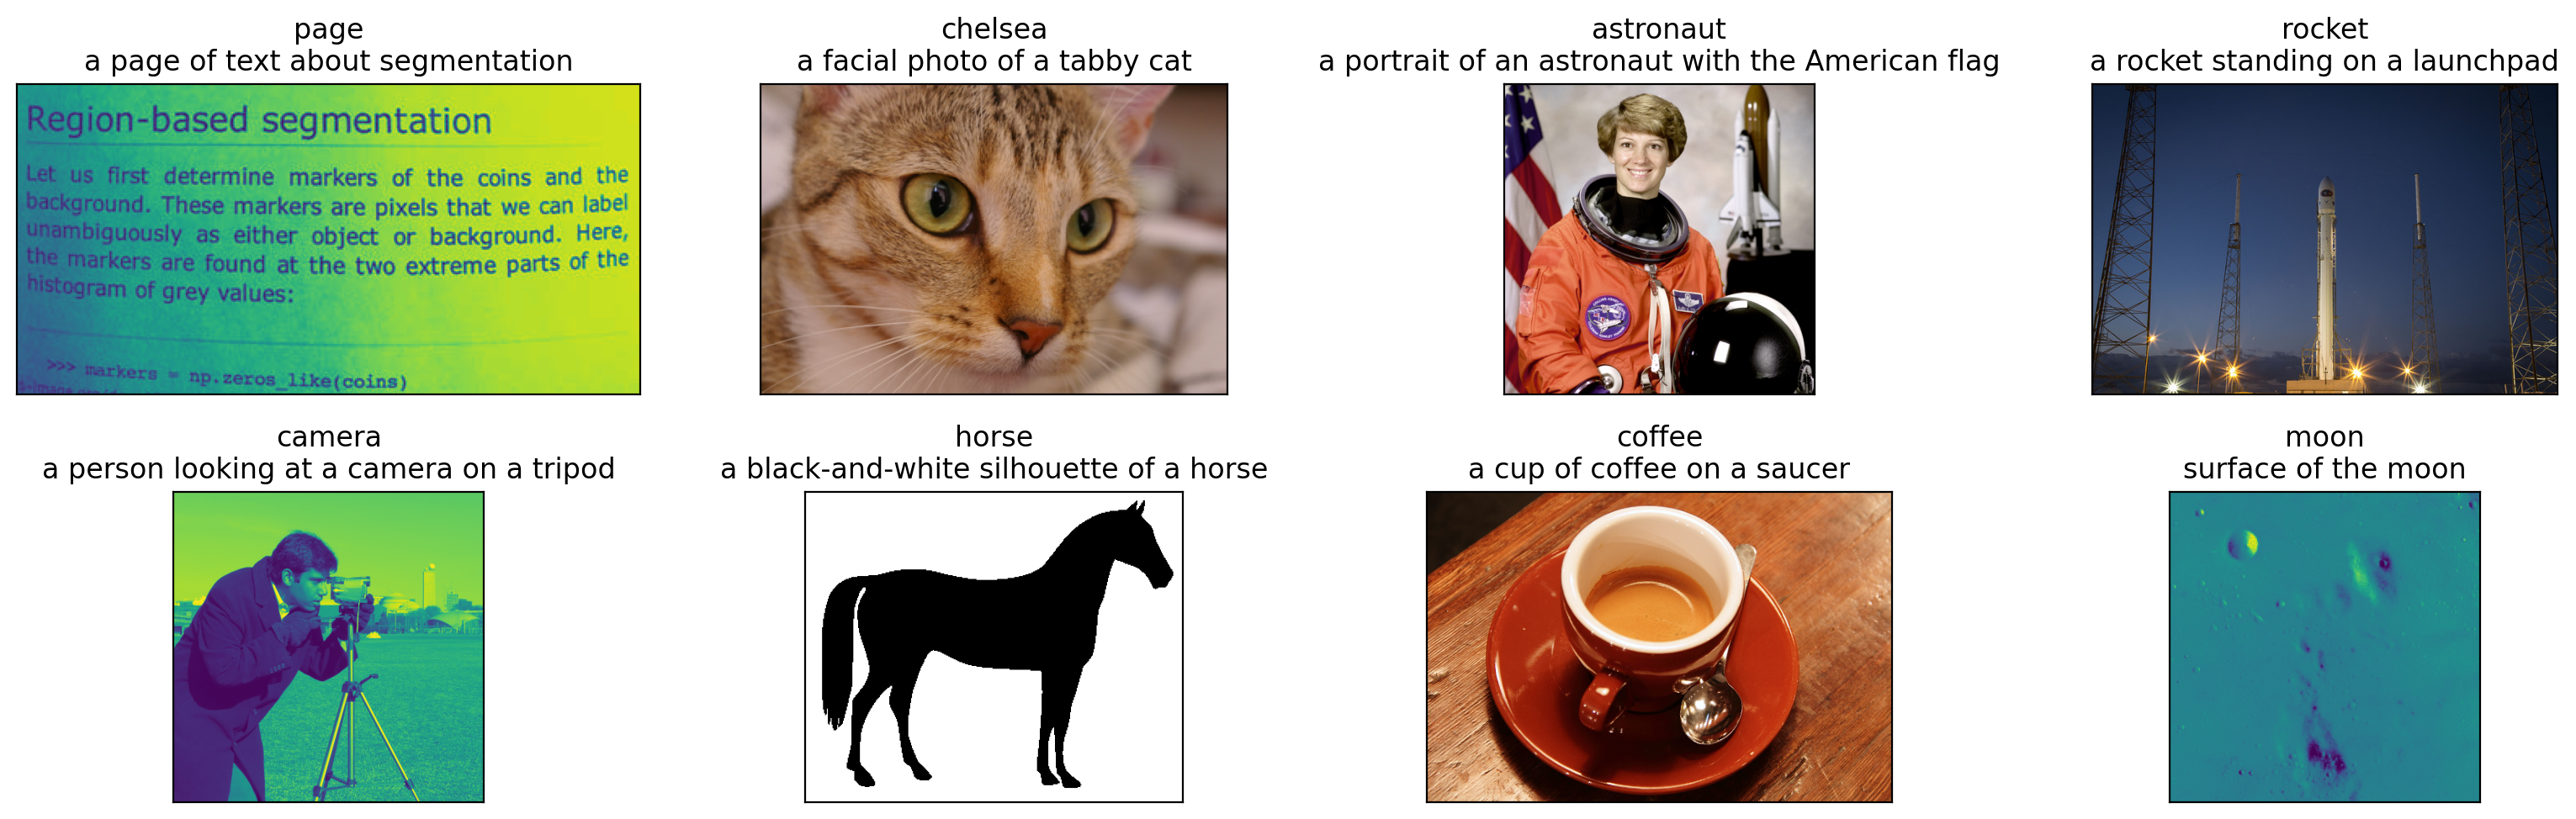

In [ ]:
from skimage import data
from PIL import Image

# Подберите названия под ваши descriptions (ключи = 'astronaut', 'camera', ...):
builtin = {
    "page": Image.fromarray(data.page()),
    "chelsea": Image.fromarray(data.chelsea()),
    "astronaut": Image.fromarray(data.astronaut()),
    "rocket": Image.fromarray(data.rocket()),
    "camera": Image.fromarray(data.camera()),
    "horse": Image.fromarray(data.horse()),
    "coffee": Image.fromarray(data.coffee()),
    "moon": Image.fromarray(data.moon())
}

original_images, images, texts = [], [], []
plt.figure(figsize=(16,5))

for name, pil_im in builtin.items():
    if name not in descriptions:
        continue
    plt.subplot(2, 4, len(images)+1)
    plt.imshow(pil_im); plt.title(f"{name}\n{descriptions[name]}")
    plt.xticks([]); plt.yticks([])

    original_images.append(pil_im)
    images.append(preprocess(pil_im))     # CLIP-preprocess -> torch.Tensor CHW
    texts.append(descriptions[name])

plt.tight_layout()


### Pre-processing



In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()


# Добавляем this is — модель лучше работает, когда мы достаточно конкретно указываем ей, что хотим получить
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

### Косинусное растояние

In [ ]:
image_features /= image_features.norm(
    dim=-1, keepdim=True
)  # нормализуем для операции сравнения
text_features /= text_features.norm(
    dim=-1, keepdim=True
)  # нормализуем для операции сравнения
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

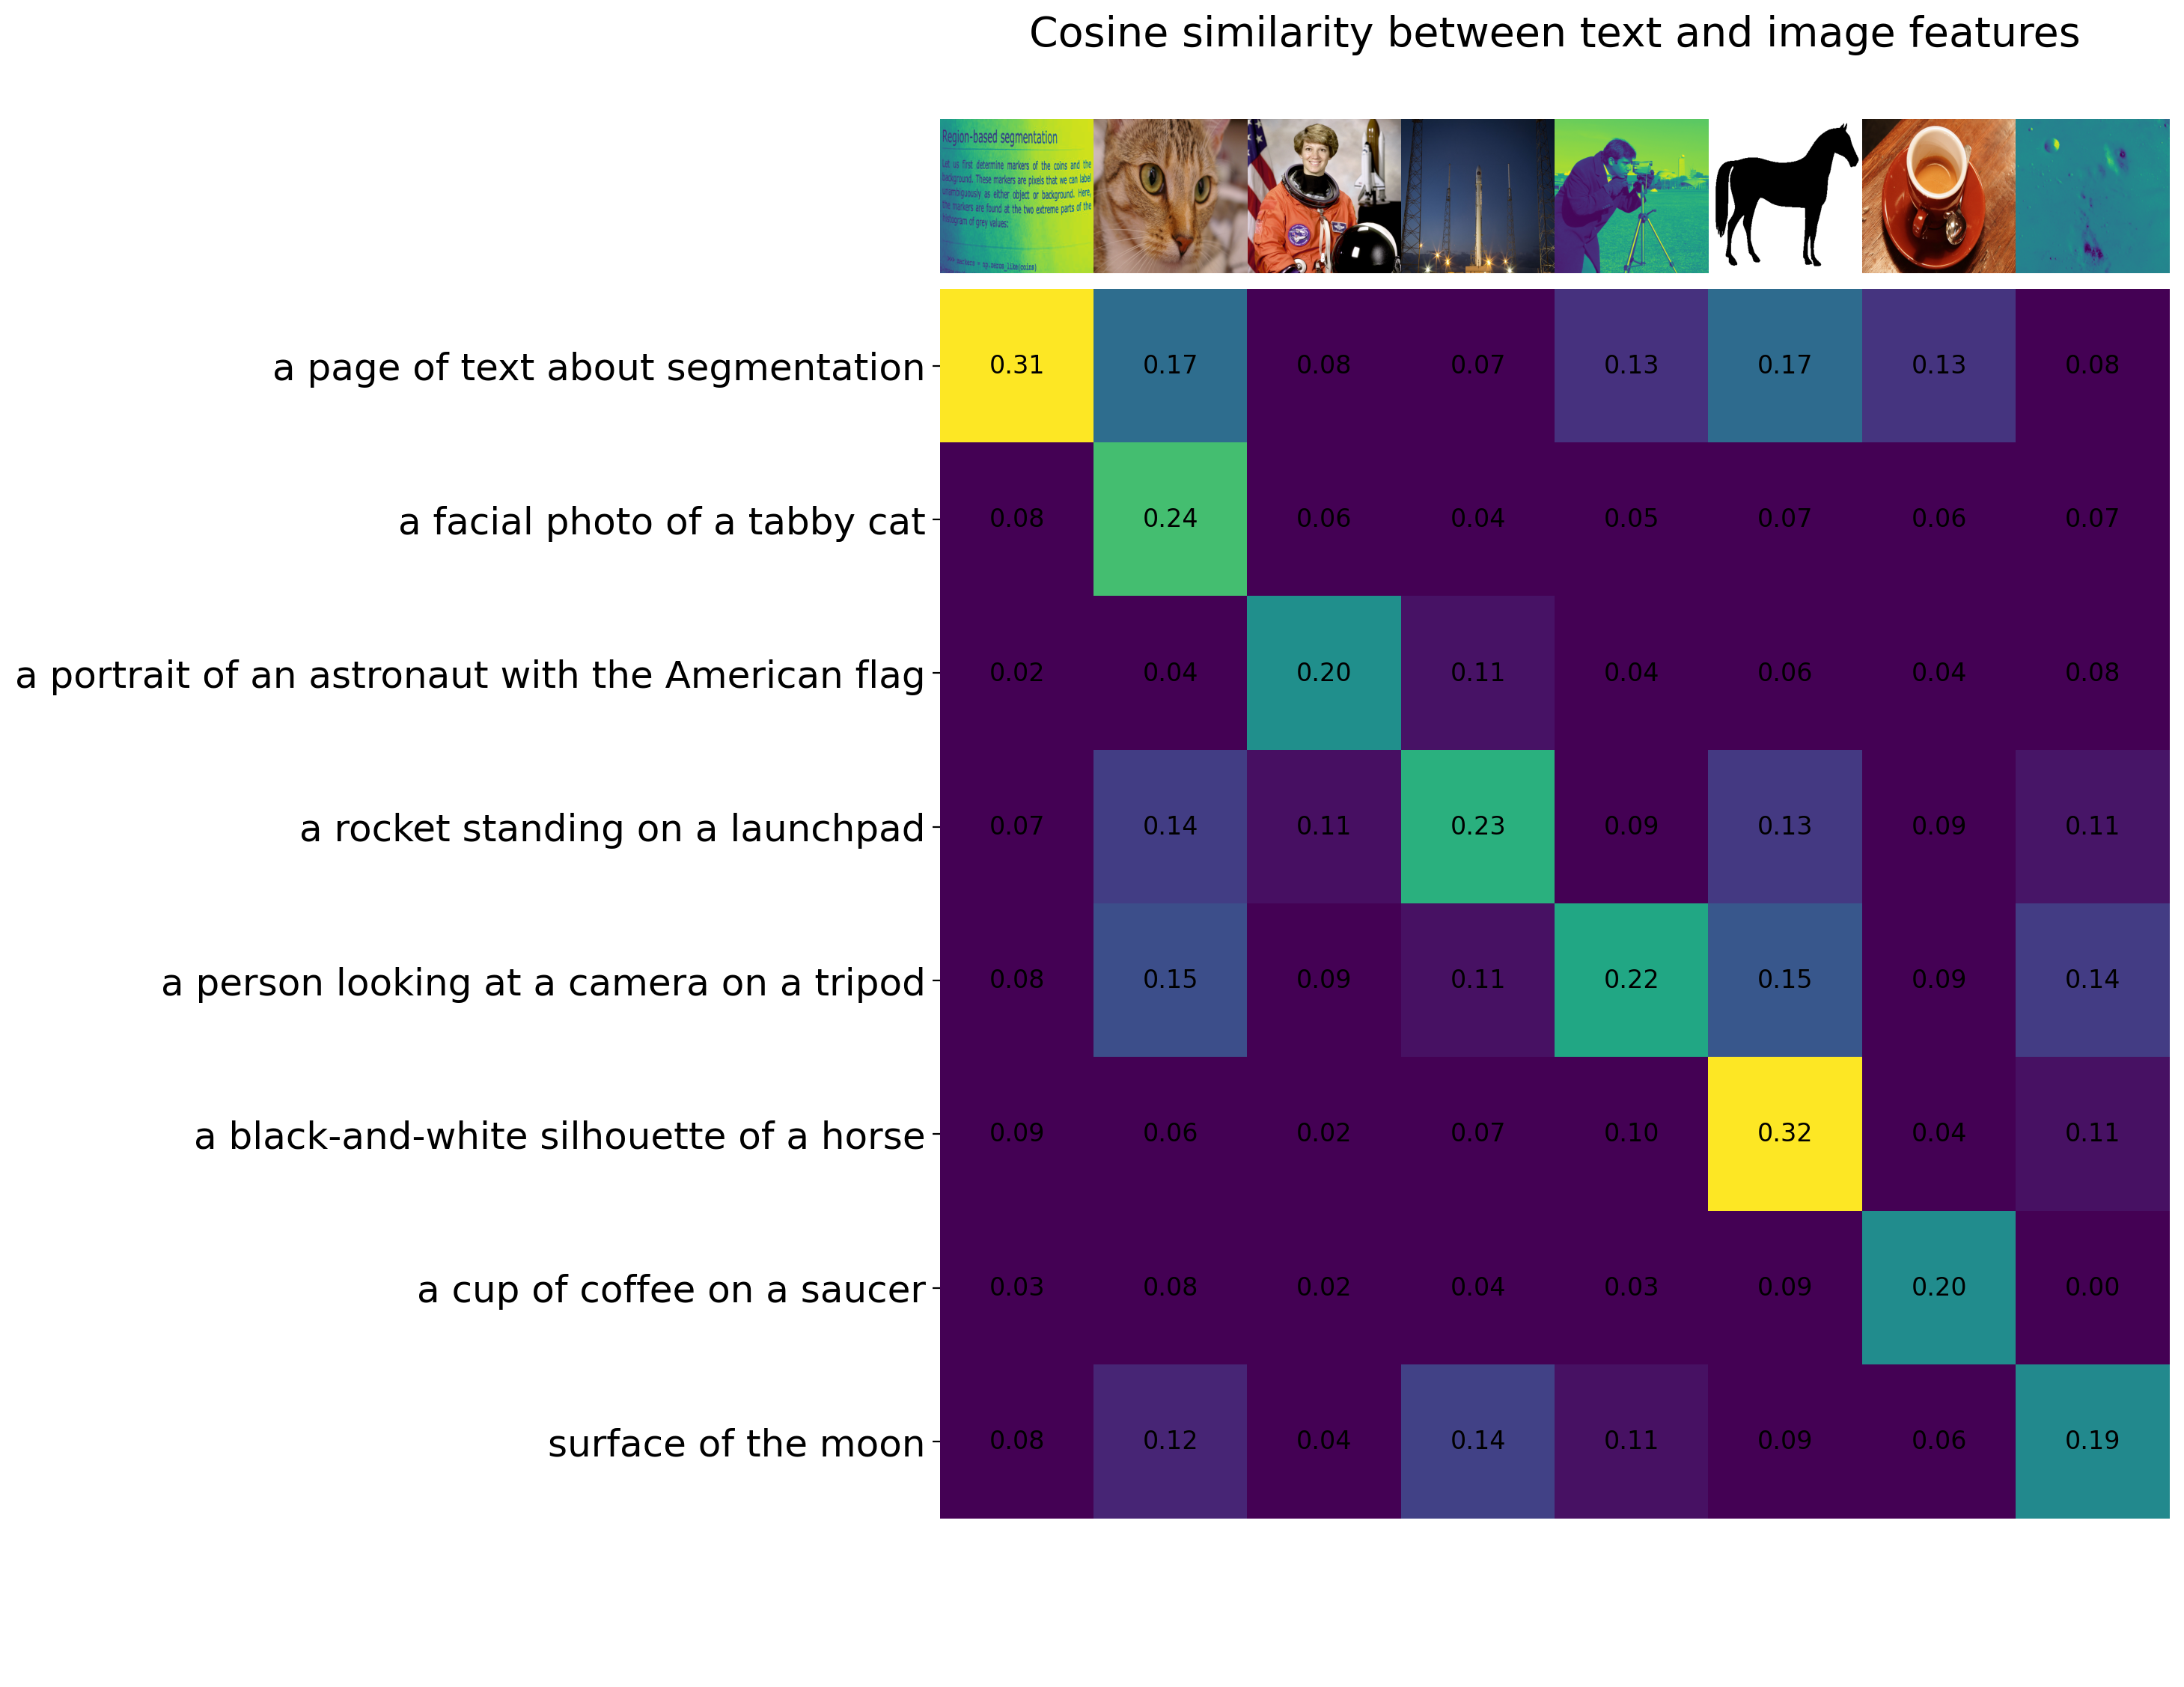

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

### Zero-shot классификация

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169M/169M [00:05<00:00, 28.5MB/s]


Теперь для каждого из классов CIFAR100 создадим искусственные подписи по шаблону "This is a photo of a {название класса}". Таким образом, мы получим 100 подписей, с которыми в дальнейшем будем сравнивать входящее изображение.

In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

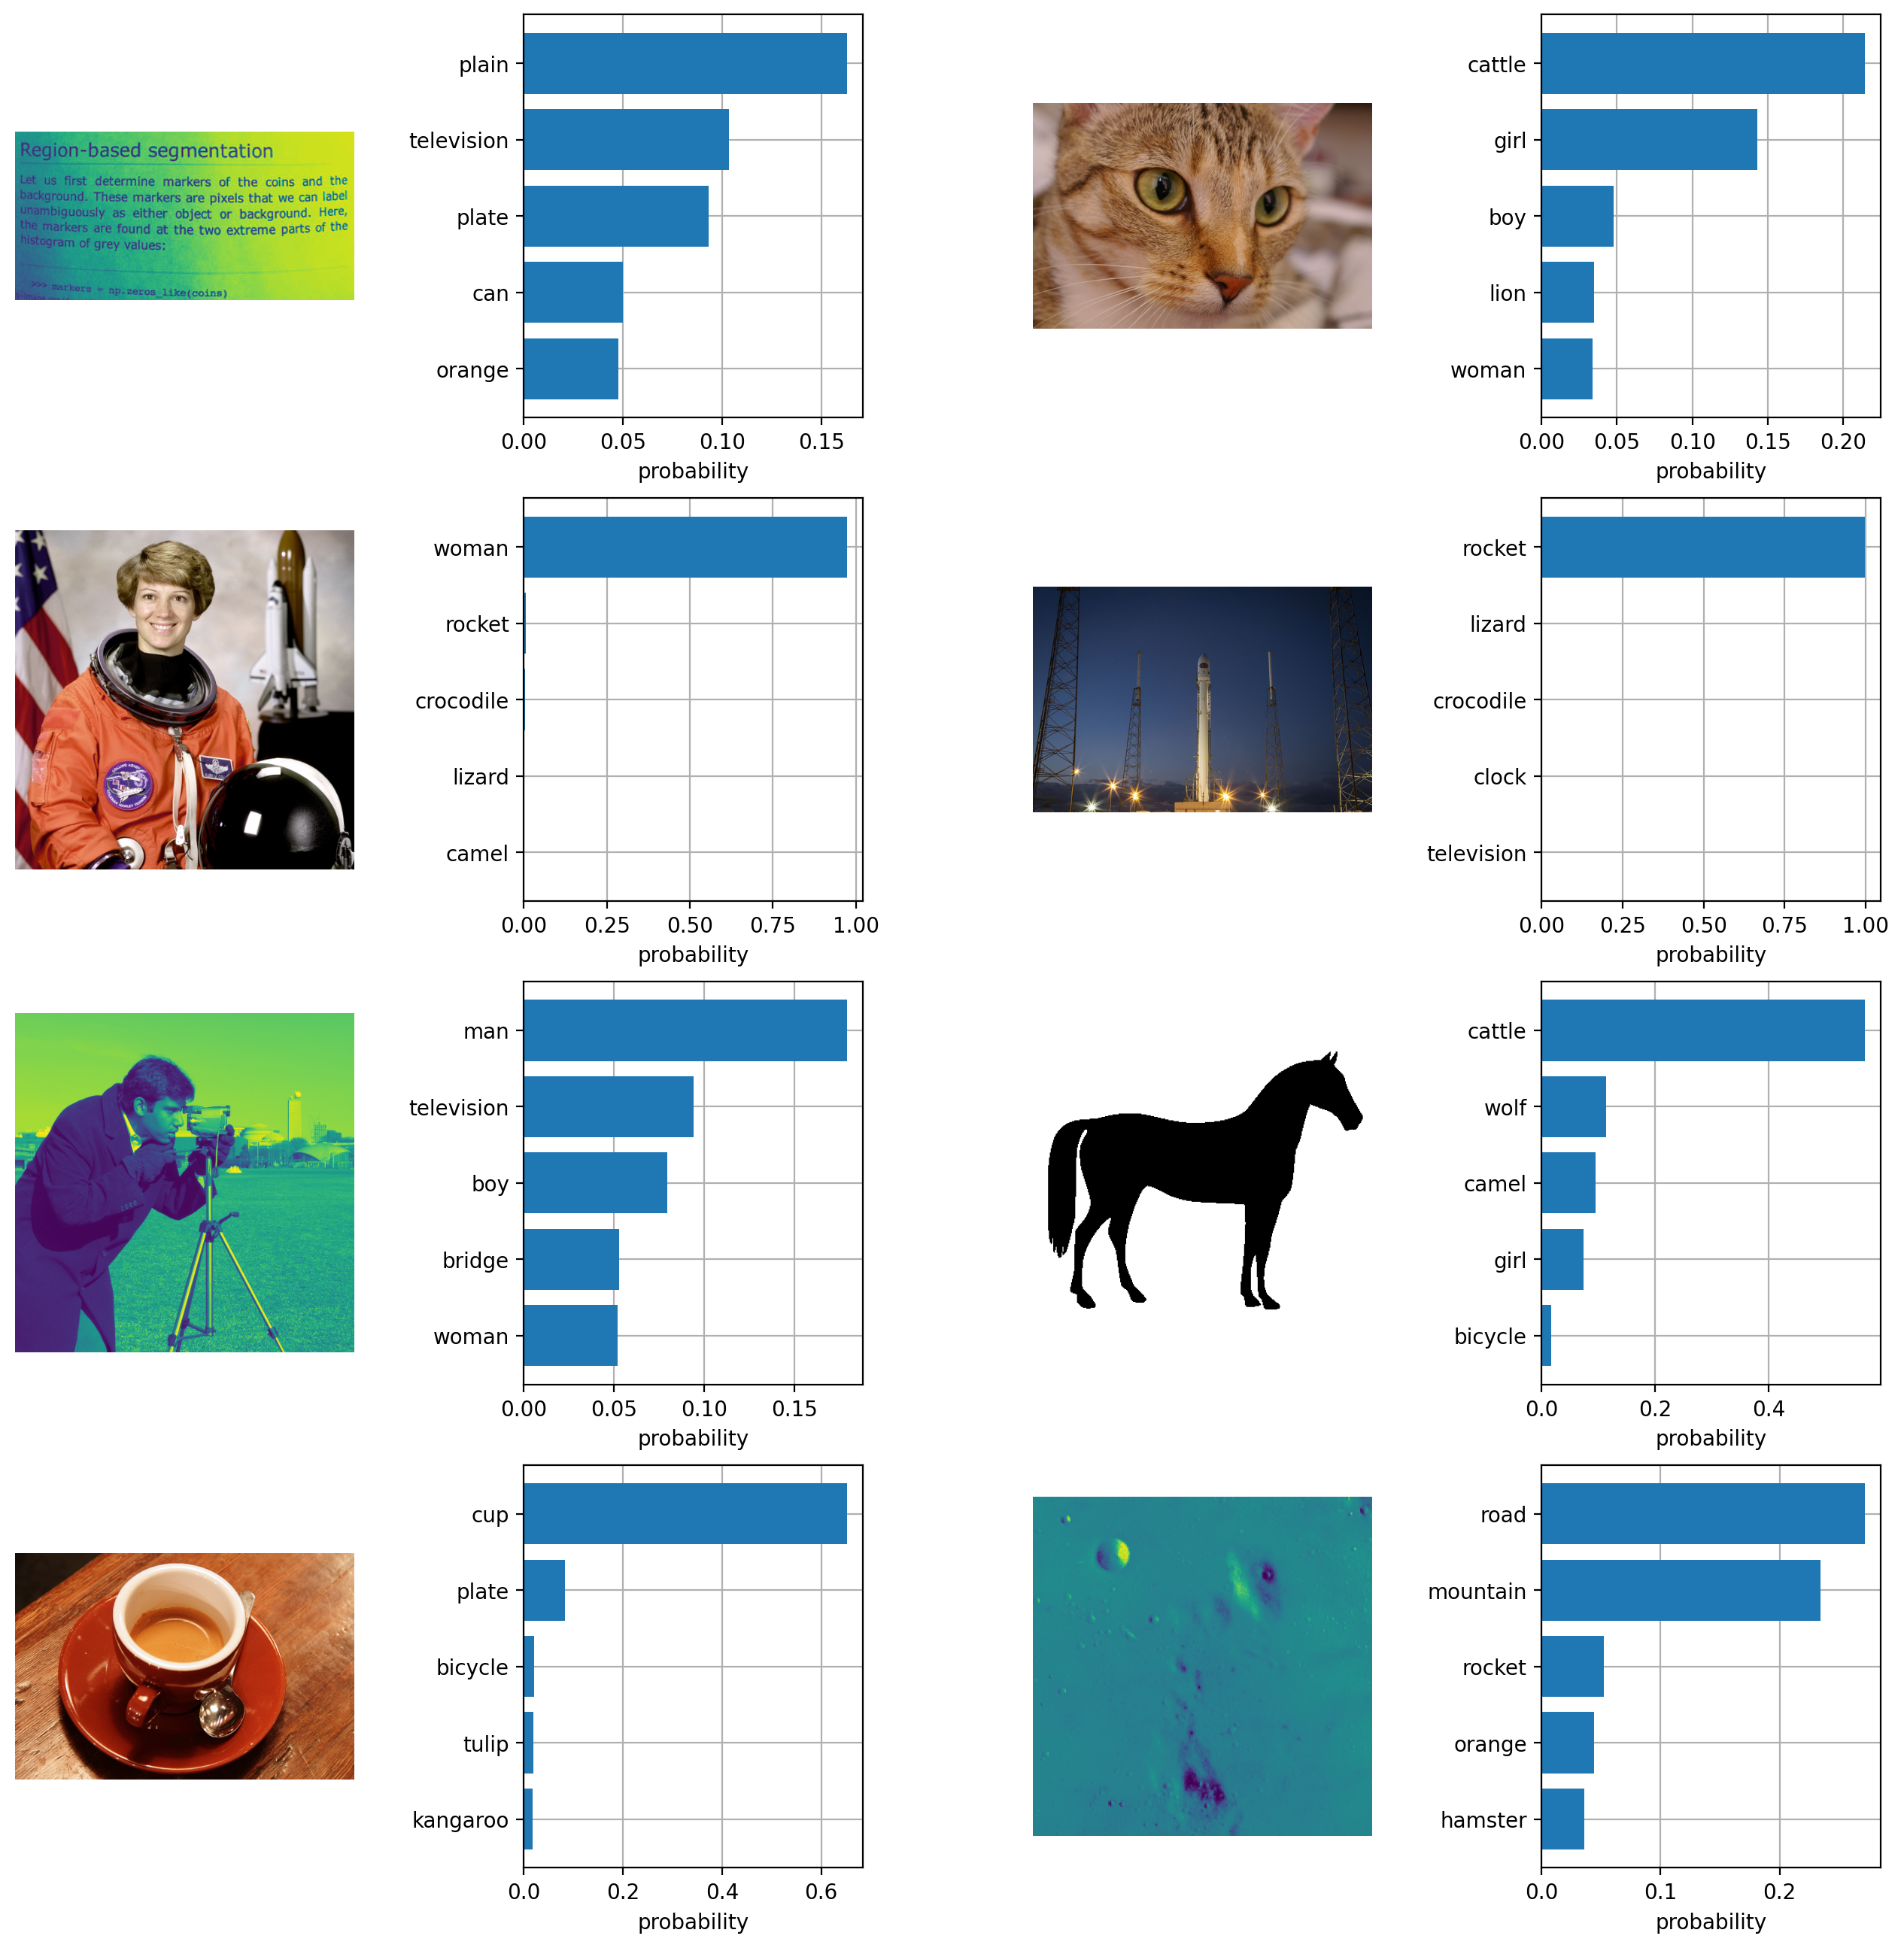

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()